In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from collections import defaultdict
from functools import reduce
from scipy.special import exp10

#  “Broder et al” butterfly picture of the directed network

In [2]:
directed_graph = "web-Stanford.txt"
undirected_graph = "facebook_combined.txt"

In [3]:
G = defaultdict(set)
# Load data into the graph data structure
with open(directed_graph, "r") as ins:
    for line in ins:
        if not line.startswith("#"):
            u, v = [int(i) for i in line.split()]
            G[u].add(v)

In [4]:
# Compute SCC
def scc(G):
    """
    Run Depth First Search to find out the finish times 
    to find each vertex in graph G.
    Pass the visited set in case we have a disconnected graph
    """
    visited, finish_times = set(), []
    for u in list(G.keys()):
        if u not in visited:
            finish_times.extend([v for v in dfs(G, u, visited)])
    
    # Reverse graph G
    GR = defaultdict(set)
    for u, nodes in G.items():
        for v in nodes:
            GR[v].add(u)
    
    """
    Compute strongly connected components by running Depth First Search
    on a reversed graph G, by exploring in reversed finish_times order.
    Pass the visited set to no explore the same components multiple times
    """
    visited, scc = set(), defaultdict(set)
    for u in reversed(finish_times):
        if u not in visited:
            scc[u].update([node for node in dfs(GR, u, visited)])
    return scc

# Run iterative DFS to prevent stack overflow in large graphs
def dfs(G, source, visited):
    stack, popped = [source], set()
    while stack:
        node = stack[-1]
        to_visit = G[node] - visited
        if node not in visited:
            visited.add(node)
            stack.extend(to_visit)
        else:
            stack.pop()
            if node not in popped:
                popped.add(node)
                yield node

In [5]:
components = sorted(scc(G).values(), key=len)
# largest SCC
giant = components[-1]
# nodes not in largest SCC
not_giant = reduce(set.union, components[:-1])

In [6]:
in_nodes = 0
for u in not_giant:
    if G[u].intersection(giant):
        in_nodes += 1

In [7]:
out_nodes = 0
for u in giant:
    if G[u].intersection(not_giant):
        out_nodes += 1

In [8]:
print("Nodes in the giant SCC: {}".format(len(giant)))
print("Nodes in the IN section of the graph: {}".format(in_nodes))
print("Nodes in the OUT section of the grap: {}".format(out_nodes))

Nodes in the giant SCC: 150532
Nodes in the IN section of the graph: 26239
Nodes in the OUT section of the grap: 2604


# Graphs

In [9]:
D = nx.read_edgelist(directed_graph, create_using=nx.DiGraph())
U = nx.read_edgelist(undirected_graph, create_using=nx.Graph())

In [18]:
def draw_distribution(num_nodes, degrees, xmax, label):
    hist = defaultdict(lambda: 0)
    for u, k in degrees:
        hist[k+1] += 1
    pairs = sorted(hist.items(), key=lambda x: x[0])
    freq = [(k, v/num_nodes) for k,v in pairs]

    x, y = zip(*freq)

    p1, = plt.loglog(x,y)
    plt.xlabel("Degree k")
    plt.ylabel("Fraction of nodes having degree k")

    x1 = np.log(np.array(x))
    y1 = np.log(np.array(y))
    A = np.vstack([x1, np.ones(len(x1))]).T
    slope1, intercept1 = np.linalg.lstsq(A, y1, rcond=None)[0]
    yfit = [t ** (slope1) for t in x]
    p2, = plt.plot(x, yfit, color = 'green')

    x2 = np.log(np.array([k for k in x if k <= xmax]))
    y2 = np.log(np.array(y[0:len(x2)]))
    A = np.vstack([x2, np.ones(len(x2))]).T
    slope2, intercept2 = np.linalg.lstsq(A, y2, rcond=None)[0]
    yfit2 = [t ** (slope2) for t in x]
    p3, = plt.plot(x, yfit2, color = 'red')
    plt.legend((p1, p2, p3), (label, 'Fitted line (all data)', 'Fitted line (ignore some data)'))

    plt.show()
    
    return (slope2, intercept2)

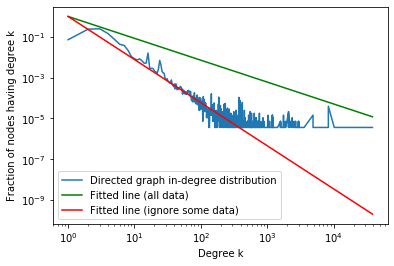

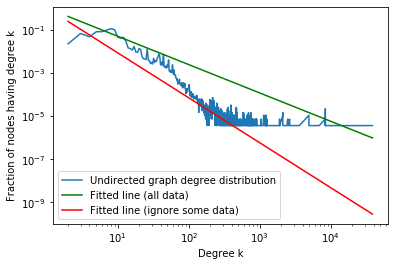

In [35]:
slope_di, intercept_di = draw_distribution(len(D.nodes()), D.in_degree(), 400, "Directed graph in-degree distribution")
slope_un, intercept_un = draw_distribution(len(D.nodes()), D.degree(), 1000, "Undirected graph degree distribution")